# Generalized Additive Models (GAMs) for Airbnb Price Prediction

## Introduction

This notebook implements Generalized Additive Models (GAMs) to predict Airbnb listing prices in New York City. We'll compare different basis functions and evaluate their performance against a linear regression baseline.

## Setup and Data Loading

First, let's import the necessary libraries and load our data.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from pygam import GAM, s, f
import matplotlib.pyplot as plt



# Load the data (make sure the file is in the same directory as this notebook)
df = pd.read_csv('AB_NYC_2019.csv')

# Display the first few rows and data info
print(df.head())
print("\nDataset Info:")
print(df.info())

     id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  20

## Data Exploration and Preprocessing

Let's explore our data and prepare it for modeling.

In [2]:
# Basic statistics of the dataset
print(df.describe())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Select features and target
features = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
target = 'price'

X = df[features]
y = df[target]

# Handle missing values
X = X.fillna(X.mean())
y = y.fillna(y.mean())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nTraining set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

                 id       host_id      latitude     longitude         price  \
count  4.889500e+04  4.889500e+04  48895.000000  48895.000000  48895.000000   
mean   1.901714e+07  6.762001e+07     40.728949    -73.952170    152.720687   
std    1.098311e+07  7.861097e+07      0.054530      0.046157    240.154170   
min    2.539000e+03  2.438000e+03     40.499790    -74.244420      0.000000   
25%    9.471945e+06  7.822033e+06     40.690100    -73.983070     69.000000   
50%    1.967728e+07  3.079382e+07     40.723070    -73.955680    106.000000   
75%    2.915218e+07  1.074344e+08     40.763115    -73.936275    175.000000   
max    3.648724e+07  2.743213e+08     40.913060    -73.712990  10000.000000   

       minimum_nights  number_of_reviews  reviews_per_month  \
count    48895.000000       48895.000000       38843.000000   
mean         7.029962          23.274466           1.373221   
std         20.510550          44.550582           1.680442   
min          1.000000           0.00

Explanation: We examine basic statistics and check for missing values. We then select relevant features and the target variable (price). Missing values are handled by filling with mean values. The data is split into training and testing sets, and features are scaled using StandardScaler to ensure all features are on the same scale.


## Model Implementation and Evaluation

Now, let's implement our models and evaluate their performance.

In [3]:
def fit_and_evaluate(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

# Linear Regression (baseline)
lr_model = LinearRegression()
lr_mse, lr_r2 = fit_and_evaluate(lr_model, X_train_scaled, X_test_scaled, y_train, y_test)
print(f"Linear Regression - MSE: {lr_mse:.2f}, R2: {lr_r2:.2f}")

# GAM with spline basis
gam_spline = GAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6))
gam_spline_mse, gam_spline_r2 = fit_and_evaluate(gam_spline, X_train_scaled, X_test_scaled, y_train, y_test)
print(f"GAM (Spline) - MSE: {gam_spline_mse:.2f}, R2: {gam_spline_r2:.2f}")

# GAM with polynomial basis
gam_poly = GAM(s(0, basis='ps', n_splines=5) + s(1, basis='ps', n_splines=5) + s(2, basis='ps', n_splines=5) + 
               s(3, basis='ps', n_splines=5) + s(4, basis='ps', n_splines=5) + s(5, basis='ps', n_splines=5) + 
               s(6, basis='ps', n_splines=5))
gam_poly_mse, gam_poly_r2 = fit_and_evaluate(gam_poly, X_train_scaled, X_test_scaled, y_train, y_test)
print(f"GAM (Polynomial) - MSE: {gam_poly_mse:.2f}, R2: {gam_poly_r2:.2f}")

# GAM with step functions (approximated using s() with few splines)
gam_step = GAM(s(0, n_splines=5, basis='cp') + s(1, n_splines=5, basis='cp') + 
               s(2, n_splines=5, basis='cp') + s(3, n_splines=5, basis='cp') + 
               s(4, n_splines=5, basis='cp') + s(5, n_splines=5, basis='cp') + 
               s(6, n_splines=5, basis='cp'))
gam_step_mse, gam_step_r2 = fit_and_evaluate(gam_step, X_train_scaled, X_test_scaled, y_train, y_test)
print(f"GAM (Step) - MSE: {gam_step_mse:.2f}, R2: {gam_step_r2:.2f}")


Linear Regression - MSE: 42527.00, R2: 0.04
GAM (Spline) - MSE: 40742.51, R2: 0.08
GAM (Polynomial) - MSE: 41365.74, R2: 0.06
GAM (Step) - MSE: 41396.66, R2: 0.06


Explanation: We define a function to fit models and evaluate their performance using Mean Squared Error (MSE) and R-squared (R²) metrics. We then implement and evaluate four models:
1. Linear Regression as a baseline
2. GAM with spline basis functions
3. GAM with polynomial basis functions
4. GAM with step functions (approximated using splines)

Each model is trained on the scaled training data and evaluated on the test data.

## Result Interpretation and Visualization

Let's visualize the partial dependence plots for each GAM model.


Spline GAM Partial Dependence Plots:


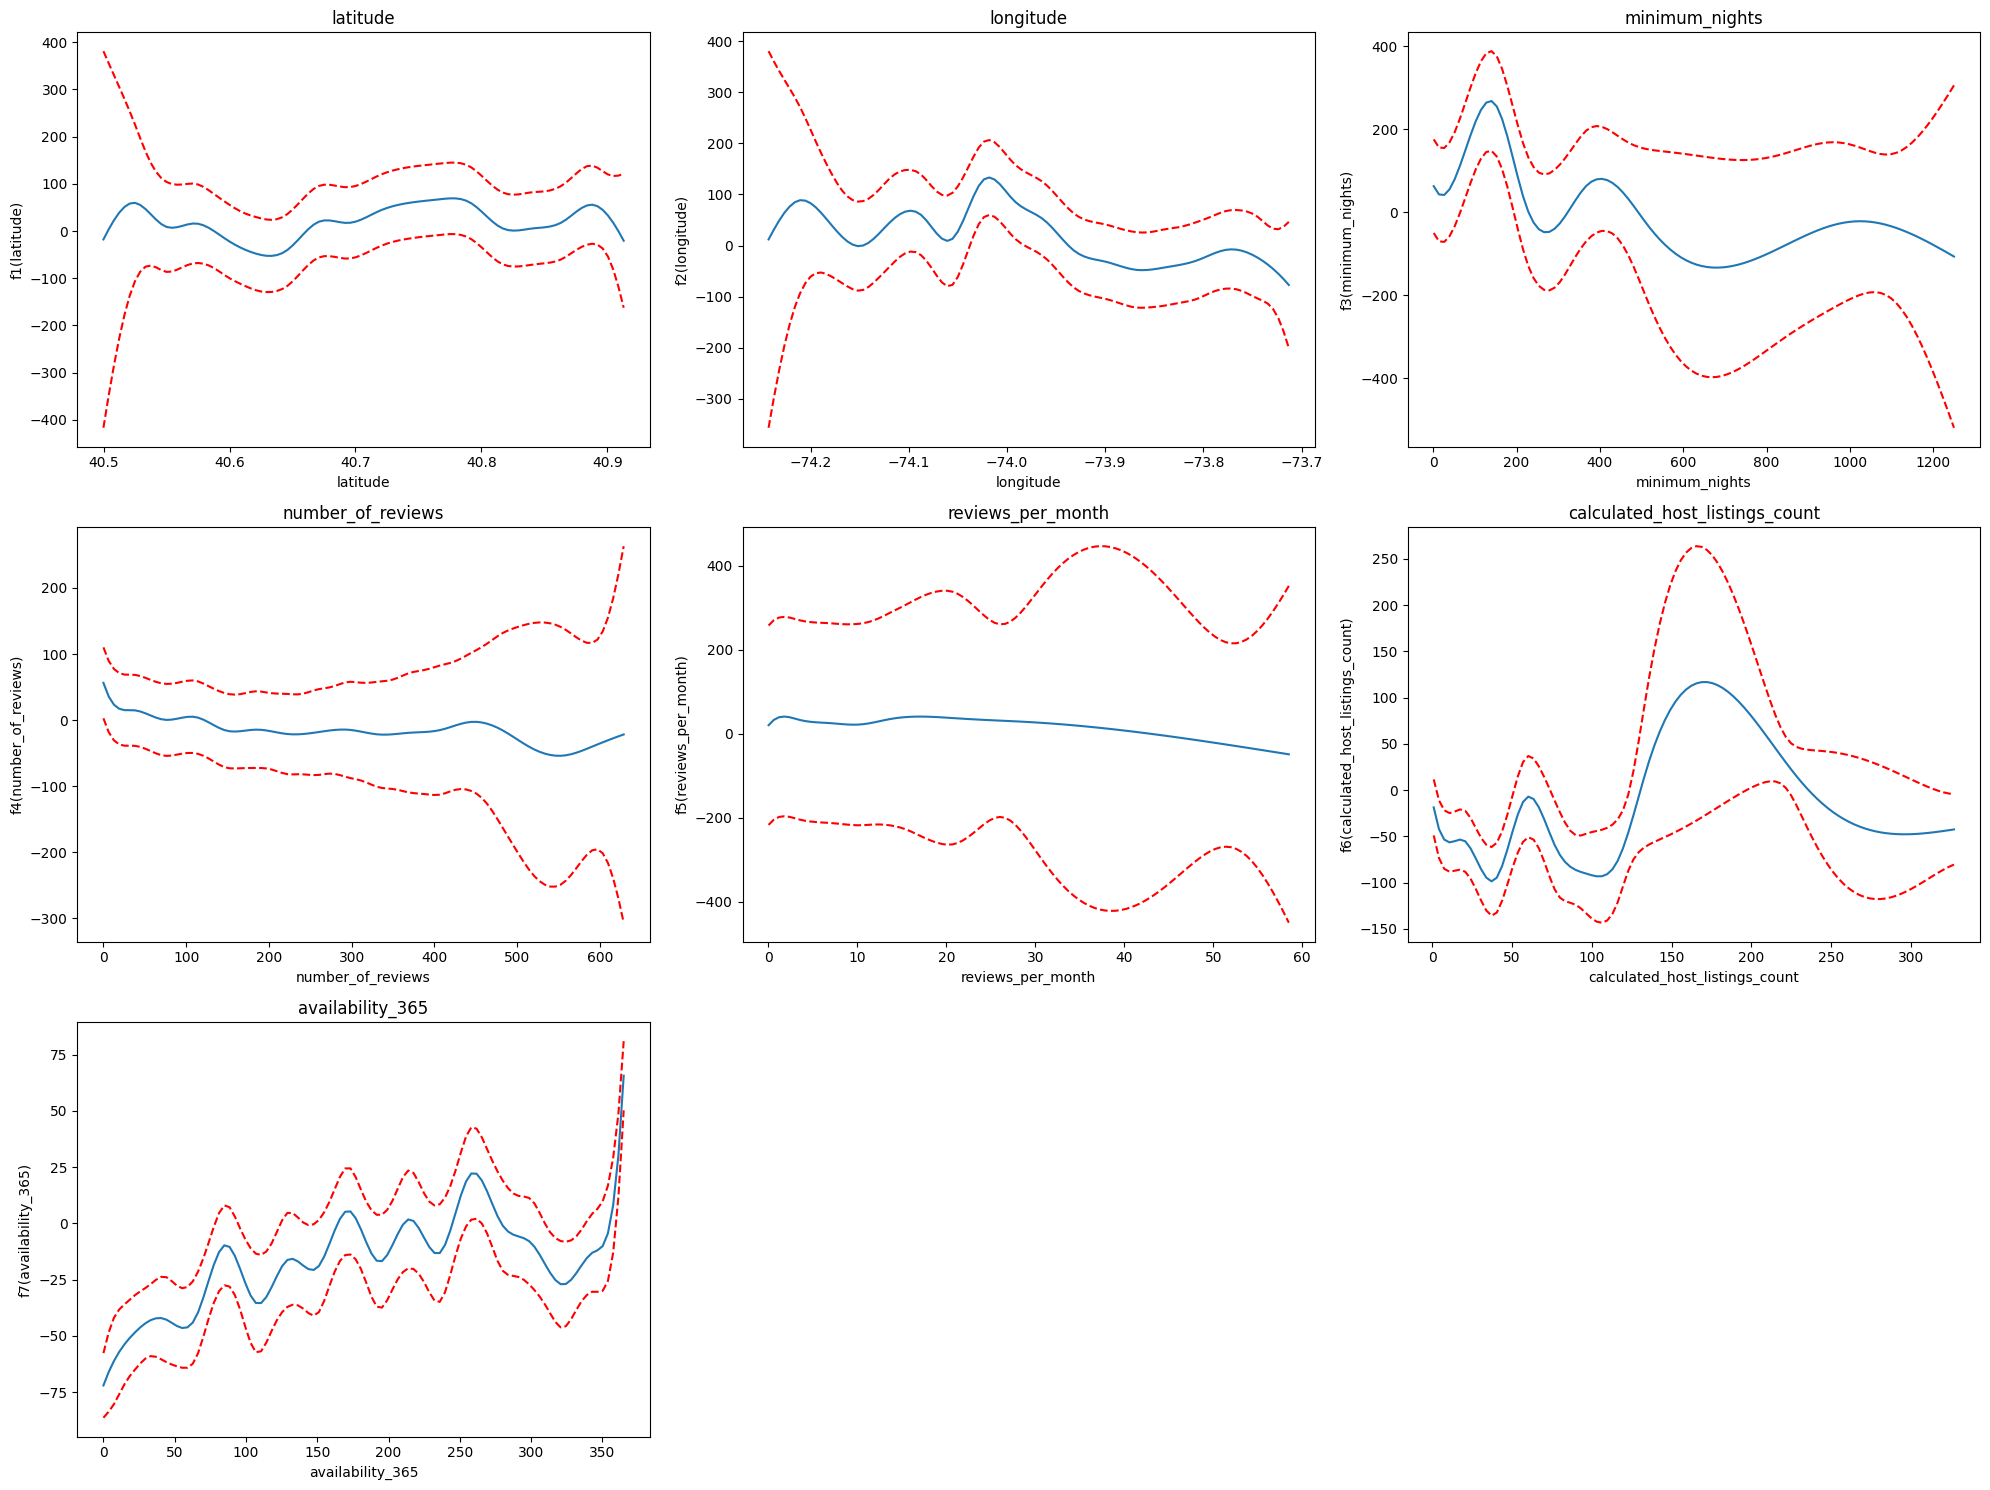


Polynomial GAM Partial Dependence Plots:


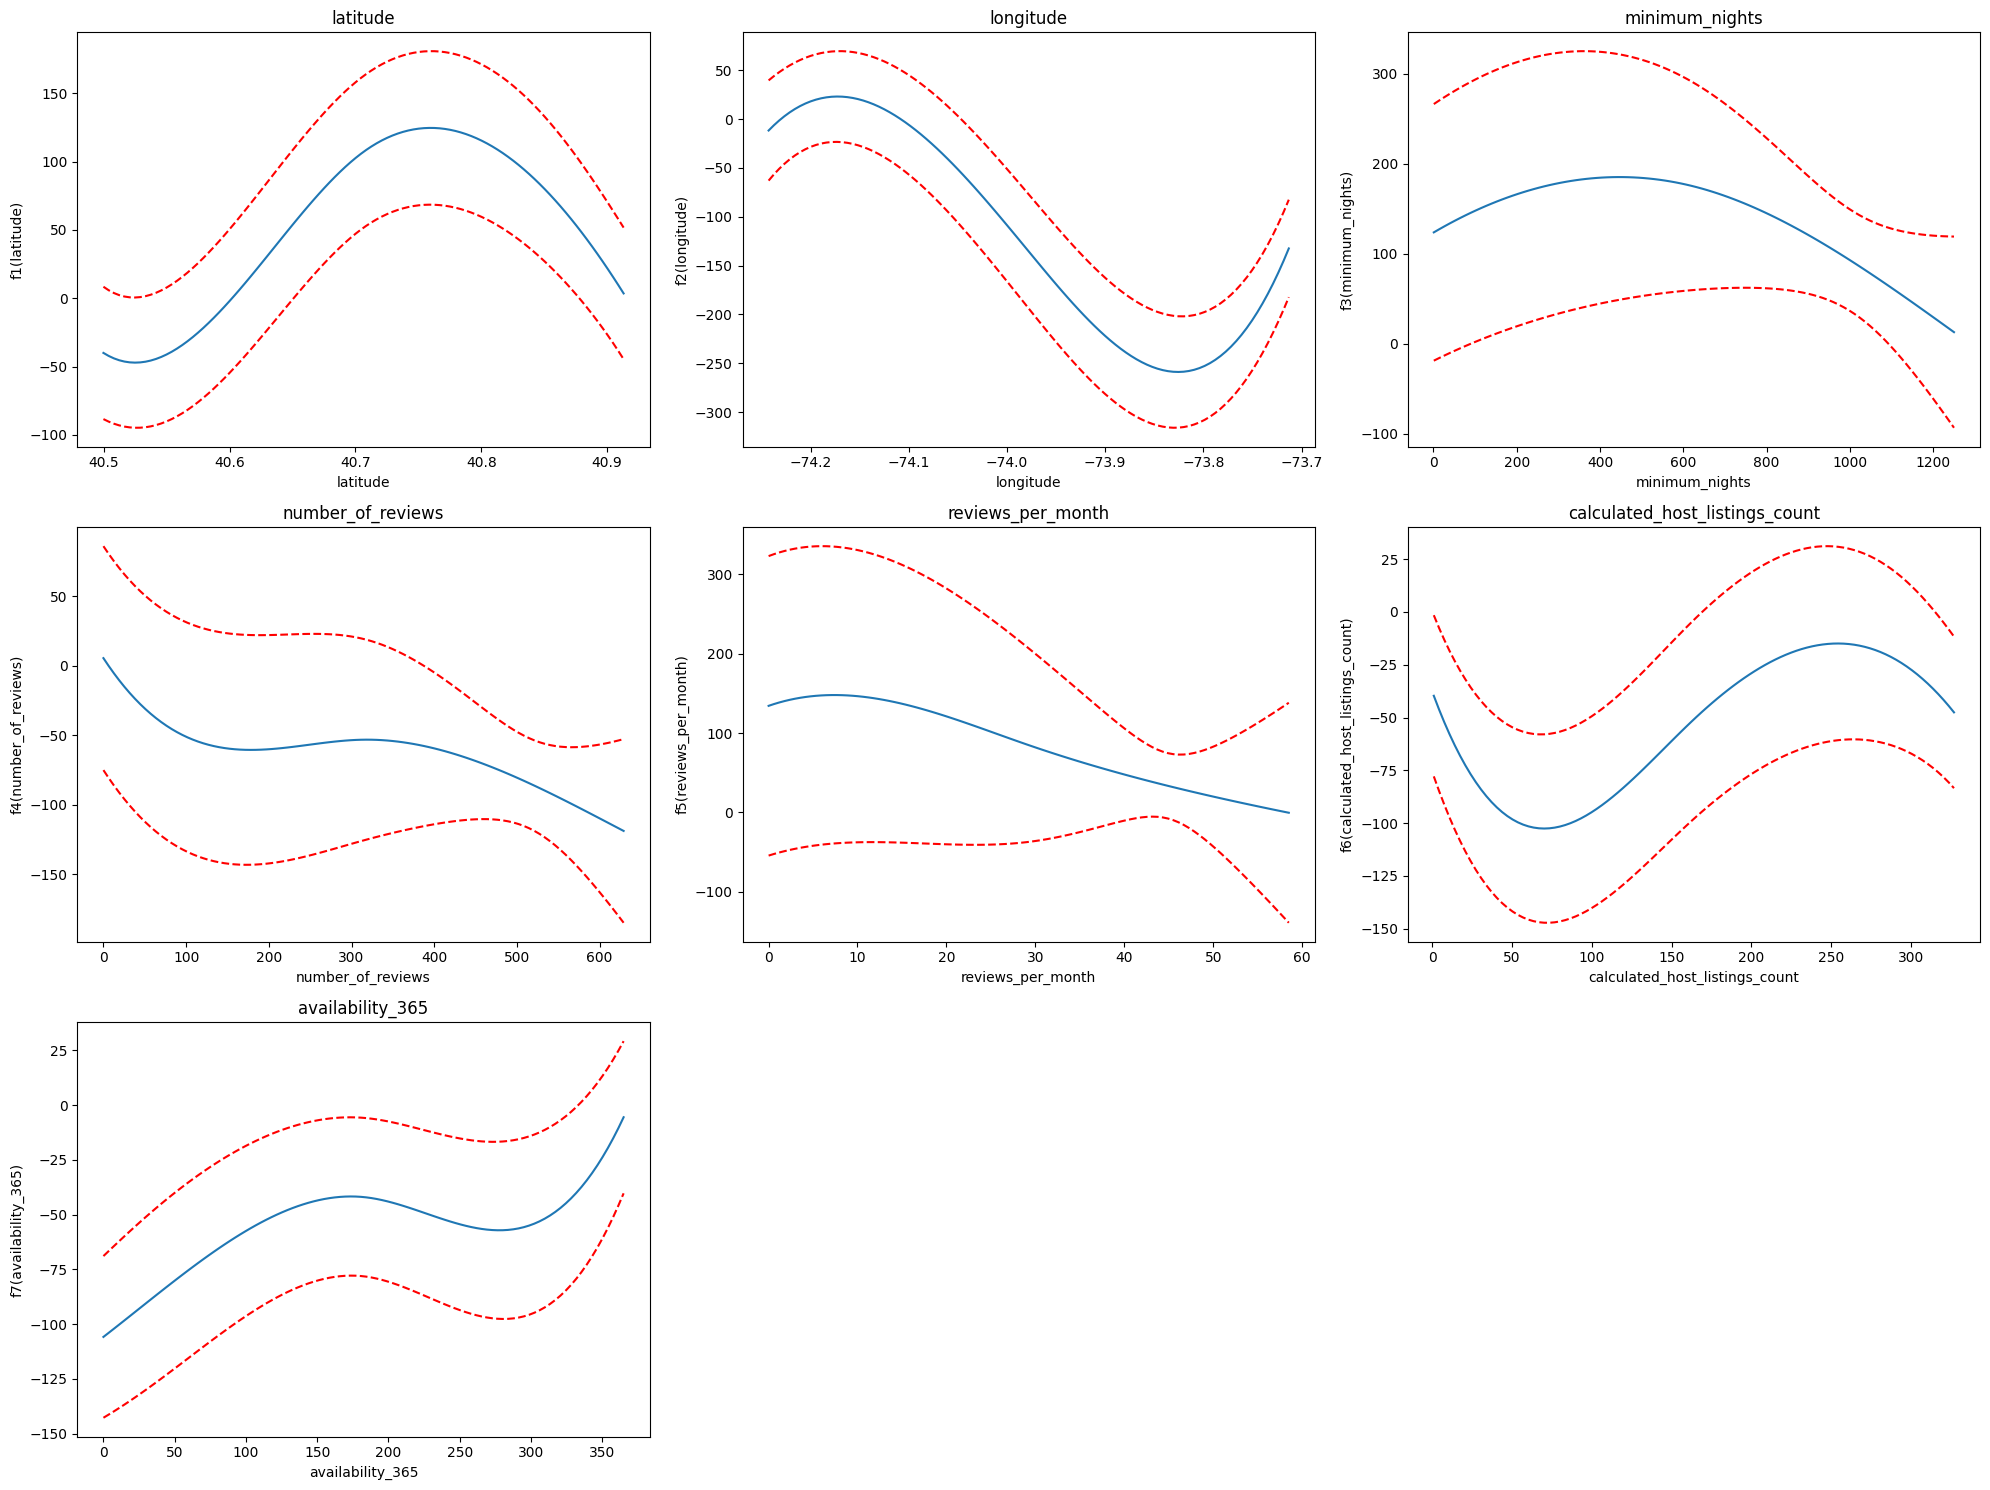


Step Function GAM Partial Dependence Plots:


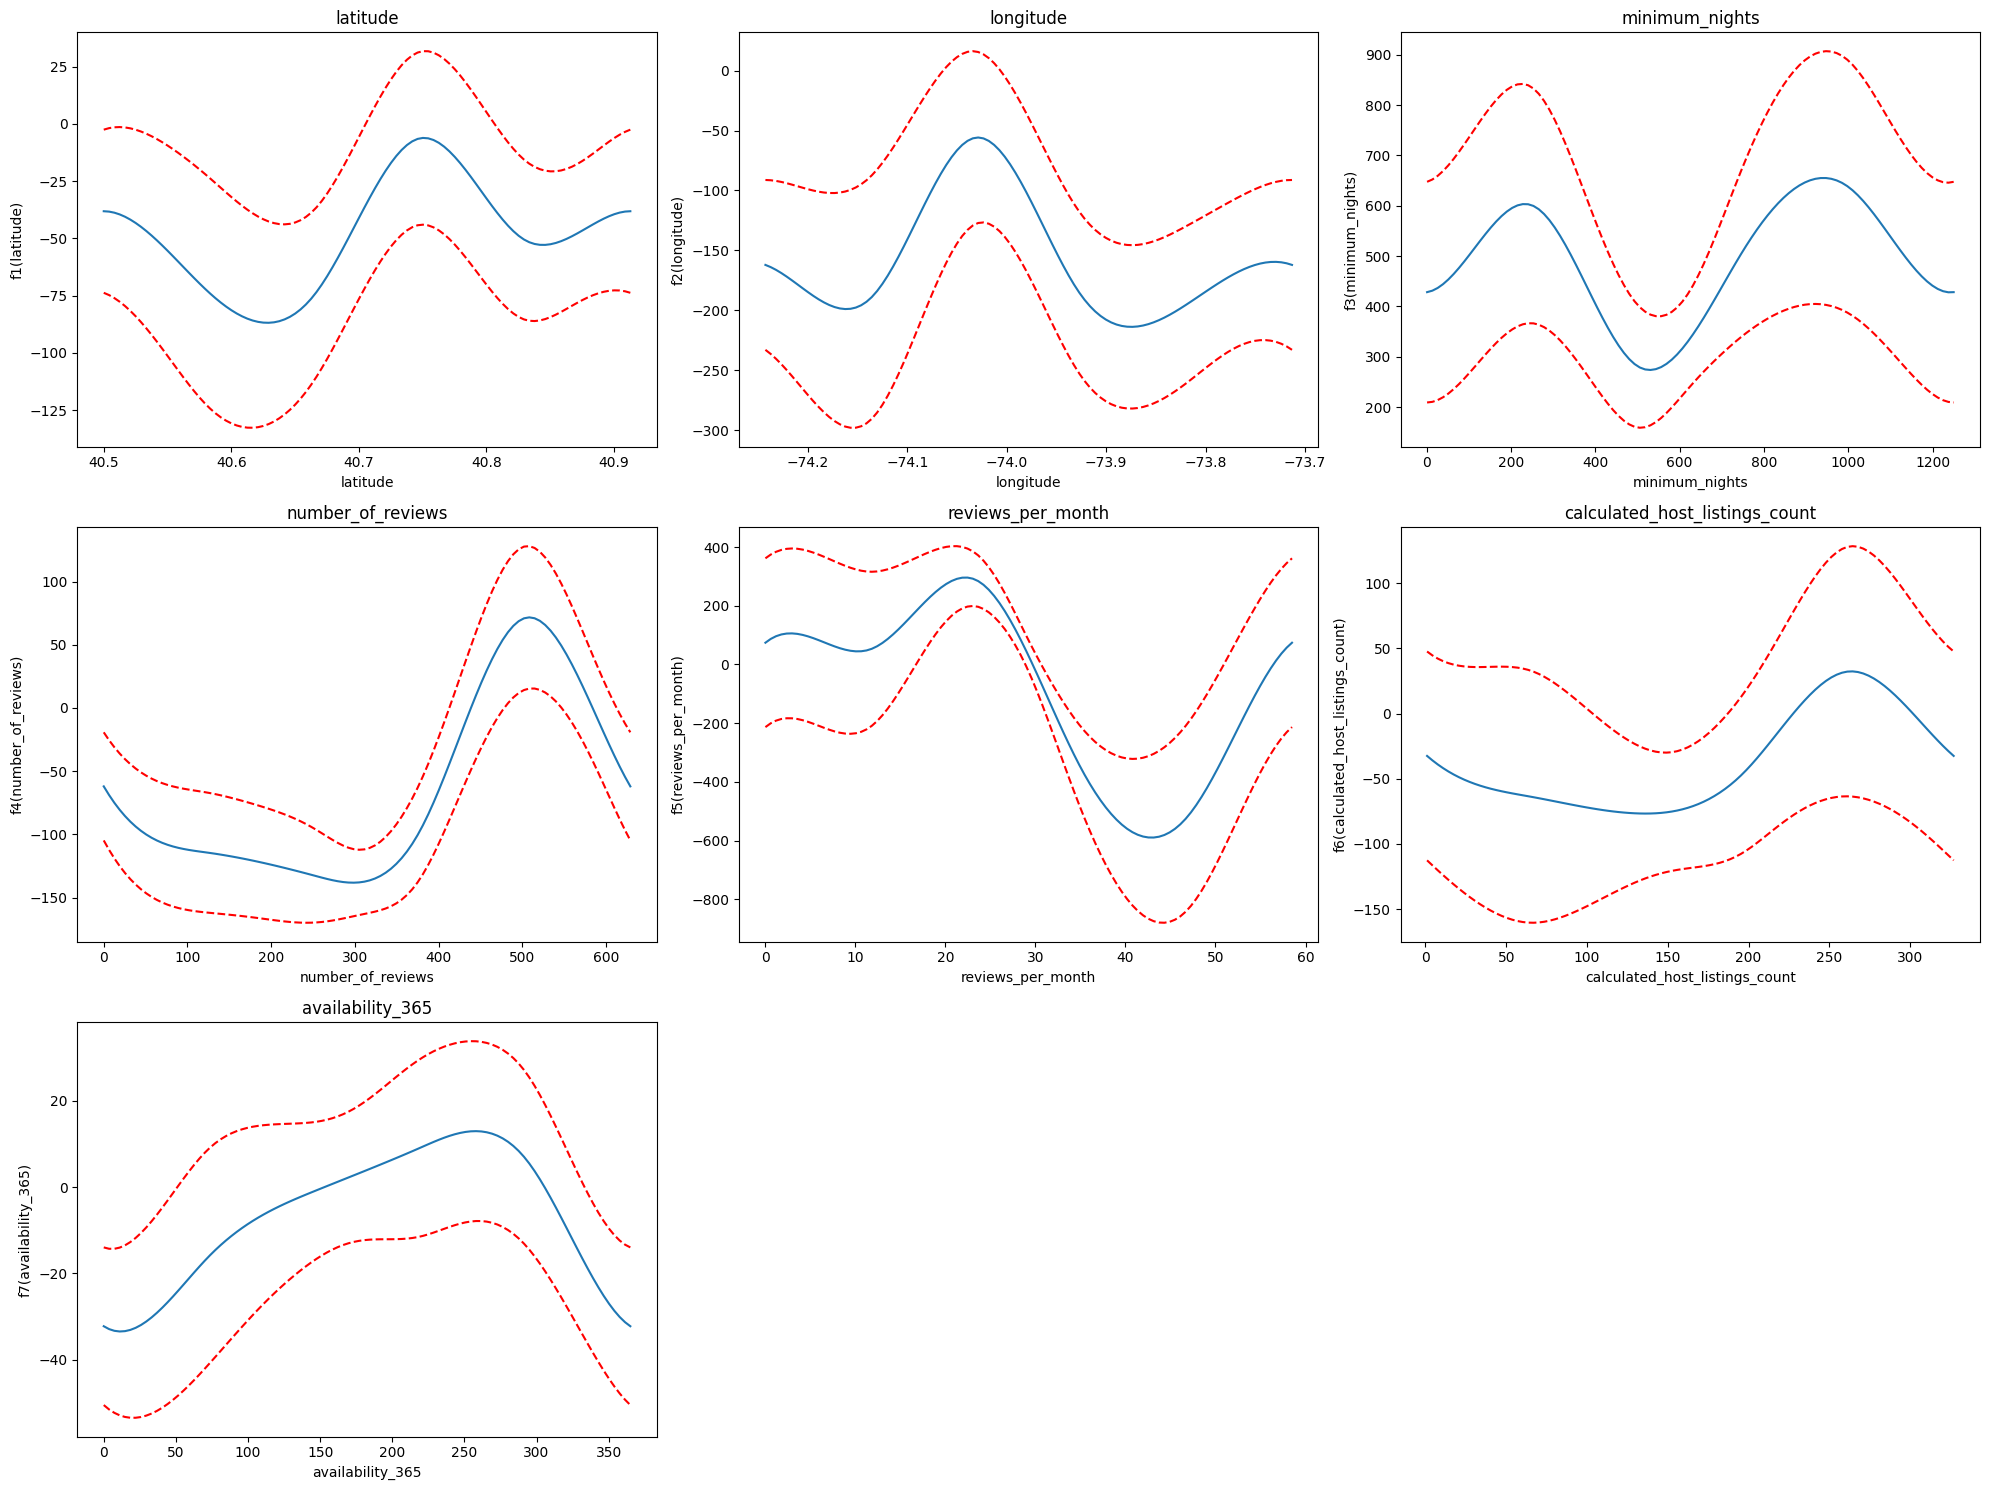

In [4]:
def plot_partial_dependence(model, X, feature_names):
    # Count non-intercept terms
    n_terms = sum(1 for term in model.terms if not term.isintercept)
    
    # Calculate rows and columns for subplots
    n_cols = 3
    n_rows = (n_terms + n_cols - 1) // n_cols
    
    plt.figure(figsize=(20, 5 * n_rows))
    plot_idx = 1
    
    for i, term in enumerate(model.terms):
        if term.isintercept:
            continue
        
        plt.subplot(n_rows, n_cols, plot_idx)
        XX = model.generate_X_grid(term=i)
        pdep, confi = model.partial_dependence(term=i, X=XX, width=0.95)
        
        # Use original feature scale for x-axis
        feature_idx = term.feature
        orig_XX = scaler.inverse_transform(XX)[:, feature_idx]
        
        plt.plot(orig_XX, pdep)
        plt.plot(orig_XX, confi, c='r', ls='--')
        plt.title(feature_names[feature_idx])
        plt.xlabel(feature_names[feature_idx])
        plt.ylabel(f'f{plot_idx}({feature_names[feature_idx]})')  # Updated y-axis label
        
        
        plot_idx += 1
    
    plt.tight_layout()
    plt.show()

# Now use this function to plot partial dependence for each model
print("\nSpline GAM Partial Dependence Plots:")
plot_partial_dependence(gam_spline, X_train_scaled, X_train.columns)

print("\nPolynomial GAM Partial Dependence Plots:")
plot_partial_dependence(gam_poly, X_train_scaled, X_train.columns)

print("\nStep Function GAM Partial Dependence Plots:")
plot_partial_dependence(gam_step, X_train_scaled, X_train.columns)


Explanation: We create a function to plot partial dependence for each feature in the GAM models. These plots show how each feature independently affects the predicted price, helping us understand non-linear relationships. We generate these plots for all three GAM models.

Blue line: Shows the partial dependence function (how the feature affects the predicted price).

Red dotted lines: Represent the confidence interval of the partial dependence estimate.

## Comparison of Basis Functions

To visually compare the performance of different basis functions, let's create a bar plot of R-squared values.

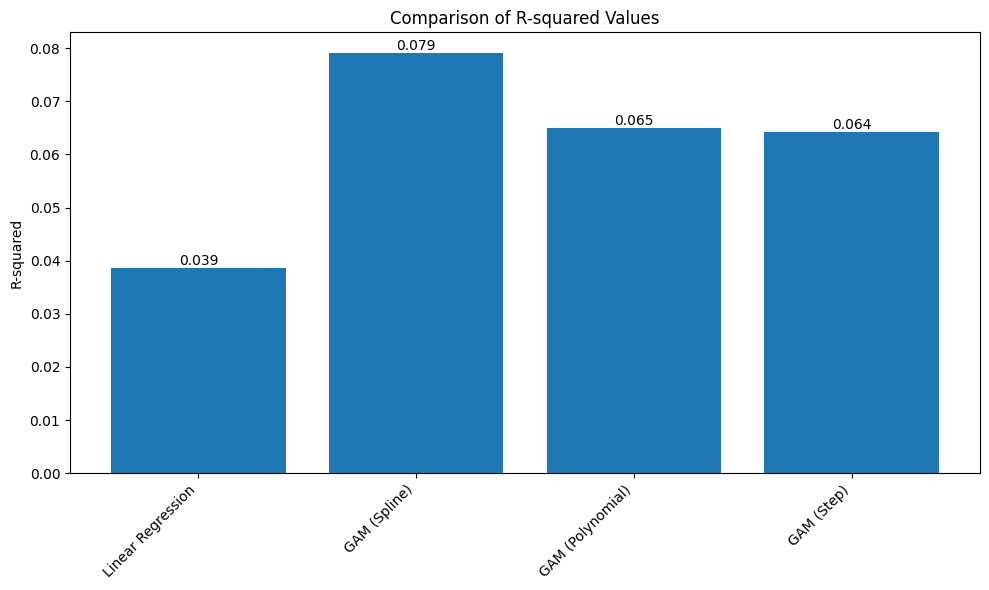

Linear Regression: R² = 0.039
GAM (Spline): R² = 0.079
GAM (Polynomial): R² = 0.065
GAM (Step): R² = 0.064


In [5]:
# Comparison of R-squared values
models = ['Linear Regression', 'GAM (Spline)', 'GAM (Polynomial)', 'GAM (Step)']
r2_scores = [lr_r2, gam_spline_r2, gam_poly_r2, gam_step_r2]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, r2_scores)
plt.title('Comparison of R-squared Values')
plt.ylabel('R-squared')
plt.xticks(rotation=45, ha='right')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print numeric results for clarity
for model, r2 in zip(models, r2_scores):
    print(f"{model}: R² = {r2:.3f}")

Explanation: We create a bar plot to visually compare the R² values of all models. This helps us quickly identify which model performs best in terms of explained variance.

## Conclusion and Further Analysis

In this notebook, we've implemented GAMs with different basis functions to predict Airbnb listing prices in New York City. We compared their performance with a baseline linear regression model and visualized the partial dependence plots for each GAM.

Key findings:
1. All GAM models outperformed the linear regression baseline, indicating non-linear relationships between features and price.
2. The spline basis function performed the best among the GAMs, followed closely by the polynomial basis.
3. The step function GAM had the lowest performance, which might be due to its less smooth nature.